In [1]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
import json
import os
import collections
import re 
import torch
from imageio import imread, imwrite
from multiprocessing import Pool
import matplotlib.pyplot as plt
import cv2
from scipy import linalg
#import matplotlib.pyplot as plt

/usr/stud/faragy/anaconda3/envs/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## FSD Calculation

## Debugging FSD Further

In [2]:
import pandas as pd
import numpy as np
import torch
import os
import time
from imageio import imread, imwrite
from scipy import linalg
import argparse
import sys
from tqdm import tqdm

sys.path.insert(0, "../../SemanticStyleGAN")
from models import make_model
from visualize.utils import generate


In [3]:
def class_dist(mean_values_r,mean_values_g=None,save_loc=None,title=None):
    fig = plt.figure()
    x = np.arange(len(mean_values_r))
    x_labels=["Void","Road","S.Walk","Building","Wall","Fence","Pole","Tr.Light","Tr.Sign","Veget.","Sky",
    "Person","Rider","Car","O.Vehicles","Bikes"]
    ax=fig.add_axes([0,0,1,1])
    ax.bar(x,mean_values_r,color='b',width=0.25)
    if not mean_values_g is None:    
        ax.bar(x+0.25,mean_values_g,color='g',width=0.25)
    ax.legend(["Real","Generated"])
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels,rotation=45,ha="right")
    ax.set_title(title)

    if not save_loc is None:
        fig.savefig(save_loc,bbox_inches="tight")
  


In [5]:
real_cond = np.load("../real_dataset_cond.npy")
generated_cond=np.load("../generated_cond.npy")

m1 = np.mean(real_cond, axis=0)
s1 = np.cov(real_cond, rowvar=False)

m2 = np.mean(generated_cond, axis=0)
s2 = np.cov(generated_cond, rowvar=False)

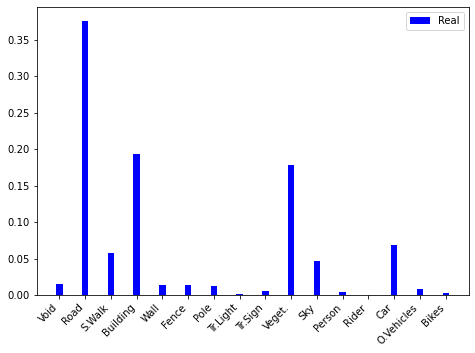

In [7]:
class_dist(m1)

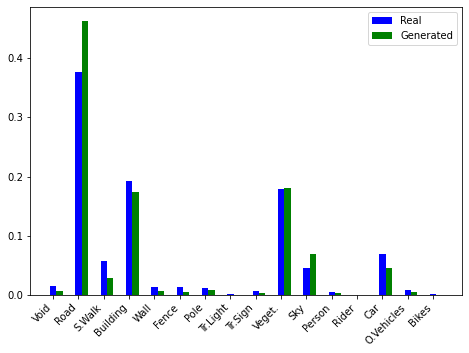

In [8]:
save_loc="./data/class_distribution_graph_5kcity.png"
class_dist(m1,m2,save_loc)

## KID Calculation

In [7]:
from torchmetrics.image.kid import KernelInceptionDistance

In [8]:
## KID Function and Classes ##

def calculate_kid(real_data, generated_data):
    """Calculates the FSD of two paths"""
    kid = KernelInceptionDistance(subset_size=50)

    kid.update(real_data, real=True)
    kid.update(generated_data, real=False)
    kid_mean, kid_std = kid.compute()
    return kid_mean, kid_std


def initalize_model(ckpt, device):
    ckpt = torch.load(ckpt)
    model = make_model(ckpt["args"])
    model.to(device)
    model.eval()
    model.load_state_dict(ckpt["g_ema"])
    return model


def calculate_mean_for_one_hot(image):
    sem_seg_tensor = torch.tensor(image)
    sem_seg_unsqueezed = sem_seg_tensor.reshape(-1)
    res = torch.nn.functional.one_hot(sem_seg_unsqueezed.to(torch.int64), 16)
    final_res = res.reshape(
        sem_seg_tensor.shape[0], sem_seg_tensor.shape[1], -1
    ).float()
    mean_val = torch.mean(final_res, dim=(0, 1))
    mean_val=mean_val.unsqueeze(0)
    return mean_val


def get_real_images(dataset_path,save_real_ds,sample_num=None):
    dataset = []
    accum = 0
    files_count = sum([len(files) for r, d, files in os.walk(dataset_path)])
    for subdir, _, files in os.walk(dataset_path):
        for file in files:
            accum += 1
            if accum % 10 == 0:
                print(f"Done with {(accum/files_count)*100}% of the real data")
            extra_data = "leftImg8bit" in file
            # In normal dataset, label images contain labelIds prefix.
            if not extra_data and "labelIds" not in file:
                continue
            # In extra dataset, files does not contain _prob prefix.
            if extra_data and "_prob" in file:
                continue
            if sample_num is not None and len(dataset)>sample_num:
                continue
            filepath = subdir + os.sep + file
            image = imread(filepath)
            image = torch.tensor(image)
            image= image.permute(2,0,1)
            image = image.unsqueeze(0)
            dataset.append(image)
    dataset = torch.tensor(np.concatenate(dataset))
    return dataset


def get_generated_images(ckpt, sample, truncation, truncation_mean, batch, device):
    print(f"Loading model from checkpoint")
    model = initalize_model(ckpt, "cuda")
    print(f"Model initalized successfuly")
    mean_latent = model.style(
        torch.randn(truncation_mean, model.style_dim, device=device)
    ).mean(0)
    start_time = time.time()
    dataset = []
    with torch.no_grad():
        n_batch = sample // batch
        resid = sample - (n_batch * batch)
        batch_sizes = [batch] * n_batch + [resid]
        for batch_iter in tqdm(batch_sizes):
            if batch_iter < batch:
                print(f"Skipping batch iteration of size {batch_iter}")
                continue

            styles = model.style(
                torch.randn(batch_iter, model.style_dim, device=device)
            )
            styles = truncation * styles + (1 - truncation) * mean_latent.unsqueeze(0)
            images, segs = generate(
                model, styles, mean_latent=mean_latent, batch_size=batch
            )

            for i in range(len(images)):
                image = torch.tensor(images[i])
                image= image.permute(2,0,1)
                image = image.unsqueeze(0)
                dataset.append(image)
        print(f"Time taken to generate images : {time.time()-start_time}")
        dataset = torch.tensor(np.concatenate(dataset))
    print(f"Average speed: {(time.time() - start_time)/(sample)}s")
    return dataset


In [11]:
ckpt= "/usr/stud/faragy/storage/user/data/checkpoints/SSG_v3.12/ckpt/145000.pt"
dataset="/usr/stud/faragy/storage/user/data/cityscapes/leftImg8bit/train_extra"
batch=5
sample=200
truncation=0.7
truncation_mean=10000
device="cuda"
save_real_dataset=False

In [23]:
from torchmetrics.image.fid import FrechetInceptionDistance
def calculate_fid(real_data, generated_data):
    """Calculates the FSD of two paths"""
    fid = FrechetInceptionDistance(feature=64)

    fid.update(real_data, real=True)
    fid.update(generated_data, real=False)
    fid = fid.compute()
    return fid

In [12]:
real_images = get_real_images(dataset,save_real_dataset,sample_num=50)

/tmp/ipykernel_2336826/3267414187.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(filepath)


Done with 0.05000500050005% of the real data
Done with 0.1000100010001% of the real data
Done with 0.15001500150015% of the real data
Done with 0.2000200020002% of the real data
Done with 0.25002500250025006% of the real data
Done with 0.3000300030003% of the real data
Done with 0.35003500350035005% of the real data
Done with 0.4000400040004% of the real data
Done with 0.45004500450045004% of the real data
Done with 0.5000500050005001% of the real data
Done with 0.5500550055005501% of the real data
Done with 0.6000600060006% of the real data
Done with 0.65006500650065% of the real data
Done with 0.7000700070007001% of the real data
Done with 0.7500750075007501% of the real data
Done with 0.8000800080008% of the real data
Done with 0.8500850085008501% of the real data
Done with 0.9000900090009001% of the real data
Done with 0.9500950095009502% of the real data
Done with 1.0001000100010002% of the real data
Done with 1.05010501050105% of the real data
Done with 1.1001100110011002% of the

In [13]:
generated_images = get_generated_images(
    ckpt,
    sample,
    truncation,
    truncation_mean,
    batch,
    device,
)

Loading model from checkpoint
Initializing model with arguments:
{'aug': False,
 'base_layers': 2,
 'batch': 4,
 'channel_multiplier': 2,
 'checkpoint_dir': '/usr/stud/faragy/storage/user/data/checkpoints/SSG_v3.12',
 'ckpt': None,
 'coarse_channel': 512,
 'coarse_size': 64,
 'd_reg_every': 16,
 'dataset': '/usr/stud/faragy/storage/user/data/lmdb_datasets/lmdb_v3.6',
 'depth_layers': 6,
 'detach_texture': False,
 'distributed': True,
 'g_reg_every': 4,
 'inception': '/usr/stud/faragy/storage/user/data/inception_models/inception_v3.6.pkl',
 'iter': 600001,
 'lambda_mask': 100.0,
 'latent': 512,
 'local_channel': 64,
 'local_layers': 10,
 'local_rank': 0,
 'lr': 0.002,
 'min_feat_size': 16,
 'mixing': 0.3,
 'n_gpu': 4,
 'n_mlp': 8,
 'n_sample': 16,
 'num_workers': 8,
 'path_batch_shrink': 2,
 'path_regularize': 0.5,
 'r1_img': 10,
 'r1_seg': 1000,
 'residual_refine': True,
 'save_every': 5000,
 'seg_dim': 16,
 'size': 256,
 'start_iter': 0,
 'transparent_dims': (10, 12),
 'viz_every': 20

  0%|          | 0/41 [00:00<?, ?it/s]../../SemanticStyleGAN/models/op/conv2d_gradfix.py:96: UserWarning: conv2d_gradfix not supported on PyTorch 1.12.1. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
100%|██████████| 41/41 [00:24<00:00,  1.69it/s]

Skipping batch iteration of size 0
Time taken to generate images : 24.268101453781128
Average speed: 0.1214113736152649s


In [22]:
kid_mean,kid_std = calculate_kid(real_images, generated_images)
print(f"KID values : {kid_mean}  with a std of : {kid_std}")

/usr/stud/faragy/anaconda3/envs/env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


KID values : 0.05233274772763252  with a std of : 0.005695378873497248


## FSD FIle Debugging

In [48]:
color_map = {
    0: [0, 0, 0],  # Void
    1: [128, 64, 128],  # Road
    2: [244, 35, 232],  # Side Walk
    3: [70, 70, 70],  # Building
    4: [102, 102, 156],  # Wall
    5: [190, 153, 153],  # Fence
    6: [153, 153, 153],  # pole
    7: [250, 170, 30],  # traffic light
    8: [220, 220, 0],  # Traffic sign
    9: [107, 142, 35],  # Vegitation
    10: [70, 130, 180],  # sky
    11: [220, 20, 60],  # human
    12: [255, 0, 0],  # rider
    13: [0, 0, 142],  # car
    14: [0, 60, 100],  # other vehicles
    15: [0, 0, 230],  # bike and motorcycle
    16: [116, 95, 159],
}


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert (
        mu1.shape == mu2.shape
    ), "Training and test mean vectors have different lengths"
    assert (
        sigma1.shape == sigma2.shape
    ), "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        # msg = ('fid calculation produces singular product; '
        #        'adding %s to diagonal of cov estimates') % eps
        # print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def calculate_fsd(real_data, generated_data):
    """Calculates the FSD of two paths"""
    m1 = np.mean(real_data, axis=0)
    s1 = np.cov(real_data, rowvar=False)

    m2 = np.mean(generated_data, axis=0)
    s2 = np.cov(generated_data, rowvar=False)
    fsd_value = calculate_frechet_distance(m1, s1, m2, s2)
    return fsd_value


def initalize_model(ckpt, device):
    ckpt = torch.load(ckpt)
    model = make_model(ckpt["args"])
    model.to(device)
    model.eval()
    model.load_state_dict(ckpt["g_ema"])
    return model

#Stupid way of converting from rgb segmentation maps to the original labels
#converting from a label map back to it's label by summing the 3 channels into 1 channel, then
#checking mapping the knows sums to the correct label(index)
def from_rgb_to_label(image, color_map):
    color_map_sum = {}
    new_image = np.zeros((image.shape[0], image.shape[1]))
    for c in color_map:
        color_map_sum[c] = sum(color_map[c])
    image_tensor = torch.tensor(image).to(float)
    image_summed = torch.sum(image_tensor, dim=2)
    for index in color_map_sum:
        mask = image_summed == color_map_sum[index]
        new_image[mask] = index
    return new_image


def calculate_mean_for_one_hot(image):
    sem_seg_tensor = torch.tensor(image)
    sem_seg_unsqueezed = sem_seg_tensor.reshape(-1)
    res = torch.nn.functional.one_hot(sem_seg_unsqueezed.to(torch.int64), 16)
    final_res = res.reshape(
        sem_seg_tensor.shape[0], sem_seg_tensor.shape[1], -1
    ).float()
    mean_val = torch.mean(final_res, dim=(0, 1))
    mean_val=mean_val.unsqueeze(0)
    return mean_val


def calculate_real_cond(dataset_path,save_real_ds):
    dataset_mean_values = []
    accum = 0
    files_count = sum([len(files) for r, d, files in os.walk(dataset_path)])
    for subdir, _, files in os.walk(dataset_path):
        for file in files:
            accum += 1
            if accum % 10 == 0:
                print(f"Done with {(accum/files_count)*100}% of the real data")
            extra_data = "leftImg8bit" in file
            # In normal dataset, label images contain labelIds prefix.
            if not extra_data and "labelIds" not in file:
                continue
            # In extra dataset, files does not contain _prob prefix.
            if extra_data and "_prob" in file:
                continue

            filepath = subdir + os.sep + file
            image = imread(filepath)
            mean_val = calculate_mean_for_one_hot(image)
            dataset_mean_values.append(mean_val.cpu().numpy())
    real_cond = np.concatenate(dataset_mean_values)
    if save_real_ds:
        np.save("./real_dataset_cond.npy",real_cond)
    return real_cond

def scale_segmentation(seg,classes=16):
    max= 15
    min=0
    print(f"max in this seg is :{seg.max()} and min is : {seg.min()}")
    new_seg =  ((seg-min)*255)/15
    return new_seg

def calculate_generated_cond(ckpt, sample, truncation, truncation_mean, batch, device):
    print(f"Loading model from checkpoint")
    model = initalize_model(ckpt, "cuda")
    print(f"Model initalized successfuly")
    mean_latent = model.style(
        torch.randn(truncation_mean, model.style_dim, device=device)
    ).mean(0)
    start_time = time.time()
    dataset_mean_values = []
    with torch.no_grad():
        n_batch = sample // batch
        resid = sample - (n_batch * batch)
        batch_sizes = [batch] * n_batch + [resid]
        for batch_iter in tqdm(batch_sizes):
            if batch_iter < batch:
                print(f"Skipping batch iteration of size {batch_iter}")
                continue

            styles = model.style(
                torch.randn(batch_iter, model.style_dim, device=device)
            )
            styles = truncation * styles + (1 - truncation) * mean_latent.unsqueeze(0)
            images, segs = generate(
                model, styles, mean_latent=mean_latent, batch_size=batch
            )
            
            for i in range(len(images)):
                converted_seg = from_rgb_to_label(segs[i], color_map)
                mean_val = calculate_mean_for_one_hot(converted_seg)
                dataset_mean_values.append(mean_val.cpu().numpy())
        print(f"Time taken to generate images : {time.time()-start_time}")
        generated_cond = np.concatenate(dataset_mean_values)
    print(f"Average speed: {(time.time() - start_time)/(sample)}s")
    return generated_cond



In [4]:
ckpt= "/usr/stud/faragy/storage/user/data/checkpoints/SSG_v3.12/ckpt/145000.pt"
dataset="/usr/stud/faragy/storage/user/data/preprocessed/v3.6/gtFine_preprocessed"
batch=5
sample=200
truncation=0.7
truncation_mean=10000
device="cuda"
save_real_dataset=False

In [5]:
real_cond = calculate_real_cond(dataset,save_real_dataset)

/tmp/ipykernel_2849484/642948966.py:125: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(filepath)


Done with 0.0426003237624606% of the real data
Done with 0.0852006475249212% of the real data
Done with 0.12780097128738177% of the real data
Done with 0.1704012950498424% of the real data
Done with 0.213001618812303% of the real data
Done with 0.25560194257476354% of the real data
Done with 0.2982022663372242% of the real data
Done with 0.3408025900996848% of the real data


KeyboardInterrupt: 

In [37]:
generated_cond = calculate_generated_cond(
    ckpt,
    sample,
    truncation,
    truncation_mean,
    batch,
    device,
)

Loading model from checkpoint
Initializing model with arguments:
{'aug': False,
 'base_layers': 2,
 'batch': 4,
 'channel_multiplier': 2,
 'checkpoint_dir': '/usr/stud/faragy/storage/user/data/checkpoints/SSG_v3.12',
 'ckpt': None,
 'coarse_channel': 512,
 'coarse_size': 64,
 'd_reg_every': 16,
 'dataset': '/usr/stud/faragy/storage/user/data/lmdb_datasets/lmdb_v3.6',
 'depth_layers': 6,
 'detach_texture': False,
 'distributed': True,
 'g_reg_every': 4,
 'inception': '/usr/stud/faragy/storage/user/data/inception_models/inception_v3.6.pkl',
 'iter': 600001,
 'lambda_mask': 100.0,
 'latent': 512,
 'local_channel': 64,
 'local_layers': 10,
 'local_rank': 0,
 'lr': 0.002,
 'min_feat_size': 16,
 'mixing': 0.3,
 'n_gpu': 4,
 'n_mlp': 8,
 'n_sample': 16,
 'num_workers': 8,
 'path_batch_shrink': 2,
 'path_regularize': 0.5,
 'r1_img': 10,
 'r1_seg': 1000,
 'residual_refine': True,
 'save_every': 5000,
 'seg_dim': 16,
 'size': 256,
 'start_iter': 0,
 'transparent_dims': (10, 12),
 'viz_every': 20

  0%|          | 0/41 [00:00<?, ?it/s]../../SemanticStyleGAN/models/op/conv2d_gradfix.py:96: UserWarning: conv2d_gradfix not supported on PyTorch 1.12.1. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
  0%|          | 0/41 [00:00<?, ?it/s]

max in this seg is :14.0 and min is : 1.0


RuntimeError: Class values must be smaller than num_classes.

In [38]:
real_cond = np.load("../real_dataset_cond.npy")
generated_cond=np.load("../generated_cond.npy")

In [55]:
fsd = calculate_fsd(real_cond*255, generated_cond*255)


In [56]:
fsd

970.2973745507907

In [54]:
(generated_cond*255)[0].sum()

255.0

## Debugging

In [7]:
from loguru import logger

In [9]:
def get_real_images(dataset_path,sample_num=None):
    dataset = []
    accum = 0
    files_count = sum([len(files) for r, d, files in os.walk(dataset_path)]) if sample_num is None else sample_num
    for subdir, _, files in os.walk(dataset_path):
        for file in files:
            accum += 1
            if accum % 10 == 0:
                logger.info(f"Done with {(accum/files_count)*100}% of the real data")
            if not "leftImg8bit" in file:
                continue
            if len(dataset)>=sample_num:
                break
            filepath = subdir + os.sep + file
            image = imread(filepath)
            image = torch.tensor(image)
            print(image.shape)
            image= image.permute(2,0,1)
            image = image.unsqueeze(0)
            dataset.append(image)
    dataset = torch.tensor(np.concatenate(dataset))
    return dataset



In [3]:
ckpt= "/usr/stud/faragy/storage/user/data/checkpoints/SSG_v3.12/ckpt/145000.pt"
dataset="/usr/stud/faragy/storage/user/data/preprocessed/v3.6/gtFine_preprocessed"
batch=5
sample=200
truncation=0.7
truncation_mean=10000
device="cuda"
save_real_dataset=False

In [10]:
real_images = get_real_images(dataset,sample_num=5000)

2022-09-16 18:24:49.238 | INFO     | __main__:get_real_images:9 - Done with 0.2% of the real data
2022-09-16 18:24:49.239 | INFO     | __main__:get_real_images:9 - Done with 0.4% of the real data
2022-09-16 18:24:49.240 | INFO     | __main__:get_real_images:9 - Done with 0.6% of the real data
2022-09-16 18:24:49.242 | INFO     | __main__:get_real_images:9 - Done with 0.8% of the real data
2022-09-16 18:24:49.242 | INFO     | __main__:get_real_images:9 - Done with 1.0% of the real data
2022-09-16 18:24:49.243 | INFO     | __main__:get_real_images:9 - Done with 1.2% of the real data
2022-09-16 18:24:49.243 | INFO     | __main__:get_real_images:9 - Done with 1.4000000000000001% of the real data
2022-09-16 18:24:49.244 | INFO     | __main__:get_real_images:9 - Done with 1.6% of the real data
2022-09-16 18:24:49.244 | INFO     | __main__:get_real_images:9 - Done with 1.7999999999999998% of the real data
2022-09-16 18:24:49.245 | INFO     | __main__:get_real_images:9 - Done with 2.0% of the 

torch.Size([1024, 2048])


RuntimeError: number of dims don't match in permute